## Final Project Submission

Please fill out:
* Student name: Wesley Yu
* Student pace: Flex
* Scheduled project review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL:

# Tanzanian Water Well Analysis

**Authors:** Wesley Yu
***

## Overview

This notebook will go over modeling process for classifying water well functionality.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, average_precision_score, precision_recall_curve

from scipy.stats import randint as sp_randInt


from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
# bring in cleaned data
data = pd.read_csv('Data/cleaned_df.csv')

In [3]:
data.head()

,amount_tsh,funder,installer,basin,district_code,lga,public_meeting,permit,extraction_type_group,management,payment,quality_group,quantity,source_type,waterpoint_type,status_group,pop_bins,construct_bins
0,1.0,other,other,Lake Nyasa,5,Ludewa,True,False,gravity,vwc,pay annually,good,enough,spring,communal standpipe,functional,below_average,1990s
1,0.0,other,other,Lake Victoria,2,Serengeti,True,True,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,above_average,2010s
2,1.0,other,other,Pangani,4,Simanjiro,True,True,gravity,vwc,pay per bucket,good,enough,dam,communal standpipe multiple,functional,above_average,2000s
3,0.0,Unicef,other,Ruvuma / Southern Coast,63,Nanyumbu,True,True,submersible,vwc,never pay,good,dry,borehole,communal standpipe multiple,non functional,below_average,1980s
4,0.0,other,other,Lake Victoria,1,Karagwe,True,True,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,none,unknown


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   installer              59400 non-null  object 
 3   basin                  59400 non-null  object 
 4   district_code          59400 non-null  int64  
 5   lga                    59400 non-null  object 
 6   public_meeting         59400 non-null  bool   
 7   permit                 59400 non-null  bool   
 8   extraction_type_group  59400 non-null  object 
 9   management             59400 non-null  object 
 10  payment                59400 non-null  object 
 11  quality_group          59400 non-null  object 
 12  quantity               59400 non-null  object 
 13  source_type            59400 non-null  object 
 14  waterpoint_type        59400 non-null  object 
 15  st

In [5]:
# make a copy of dataframe 
df = data.copy()

# assigning features and target

X = df.drop('status_group', axis = 1)
y = df.status_group

Changing status group to binary. 
* functional = 0
* non funcation = 1

In [6]:
y.replace({'functional': 0, 'non functional': 1}, inplace = True)

In [7]:
y.value_counts()

0    36576
1    22824
Name: status_group, dtype: int64

Creating pipeline for preprocessing steps. Most features are categorical, numeric features have already been changed to either binary or ordinal. Other preprocessing steps can be added if needed.

In [8]:
cat_cols = list(X.select_dtypes('object').columns)

In [9]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [10]:
CT = ColumnTransformer(transformers=[('ohe', ohe, cat_cols)],
                                       remainder='passthrough')

Splitting data to train and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Baseline Model

For our baseline model we will a logistic regression model and optimize for f1 score, as this metric will have a good balance of precision and recall. We will monitor precision to keep the number of false positives low, so that unnecessary resources will not be wasted if a water point was predicted to be non functional but it was in fact functional. We will also monitor recall to ensure we are identifying a good amount of non functional water points.

In [12]:
logr = LogisticRegression(random_state=42, max_iter = 700)

In [13]:
logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            ('logreg', logr)])

In [14]:
cv_logr = cross_validate(logreg_model_pipe, X_train, y_train, cv = 5, scoring = ['f1', 'precision', 'recall'])

In [15]:
cv_logr['test_f1'].mean()

0.7223938163445164

In [16]:
cv_logr['test_f1'].std()

0.004721697485707323

In [17]:
cv_logr['test_precision'].mean()

0.819955372376244

In [18]:
cv_logr['test_recall'].mean()

0.6456310308150257

In [19]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('logreg', LogisticRegression(

Visualizing predictions with confusion matrix.

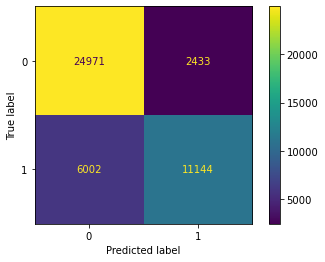

In [20]:
plot_confusion_matrix(logreg_model_pipe, X_train, y_train);

Above method may not be representative of actual performance. We can use predictions from cross_val_predict to construct a confusion matrix.

In [21]:
logreg_hat = cross_val_predict(logreg_model_pipe, X_train, y_train, cv = 5)

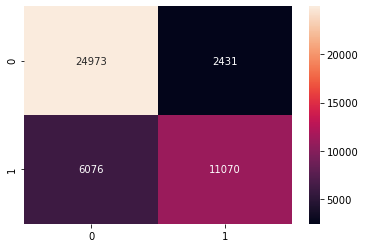

In [22]:
cm = confusion_matrix(y_train, logreg_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Not much of a difference, but we will keep checking. We are aiming to reduce false positives (2434) and false negatives (6072), while trying to increase true positives (11074).

In [23]:
# creating a dataframe to store model results

model_results = pd.DataFrame(columns=['Model', 'mean f1_score', 'std f1_score', 'mean precision', 'mean recall'])

In [24]:
model_results = model_results.append({'Model': 'logred_model_pipe',
                      'mean f1_score': round(cv_logr['test_f1'].mean(), 4),
                      'std f1_score': round(cv_logr['test_f1'].std(), 4),
                      'mean precision': round(cv_logr['test_precision'].mean(), 4),
                      'mean recall': round(cv_logr['test_recall'].mean(), 4)}, ignore_index = True)

Baseline logistic regression performed decently with an average f1 score of 72%. Model had a precision of 82% and a recall of 65%. Confusion matrix shows 2464 false positives, 6003 false negatives, and 11143 true positives.

## Other classification algorithms
### Decision tree
Based on our features a decision tree model may be able to out perform a logistic regression model due to the majority of categorical features.

In [25]:
dt = DecisionTreeClassifier(random_state = 42)
dt_model_pipe = Pipeline([('ct', CT), ('dt', dt)])

In [26]:
cv_dt = cross_validate(dt_model_pipe, X_train, y_train, cv = 5, scoring = ['f1', 'precision', 'recall'])

In [27]:
cv_dt['test_f1'].mean()

0.7620123037220652

In [28]:
cv_dt['test_f1'].std()

0.00544747827495181

In [29]:
cv_dt['test_precision'].mean()

0.8127404584585436

In [30]:
cv_dt['test_recall'].mean()

0.7173096730255657

In [31]:
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('dt', DecisionTreeClassifier(

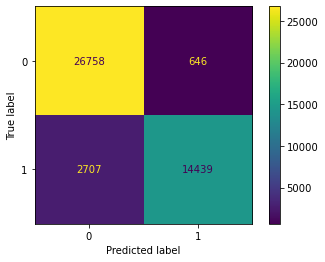

In [32]:
plot_confusion_matrix(dt_model_pipe, X_train, y_train);

In [33]:
dt_hat = cross_val_predict(dt_model_pipe, X_train, y_train, cv = 5)

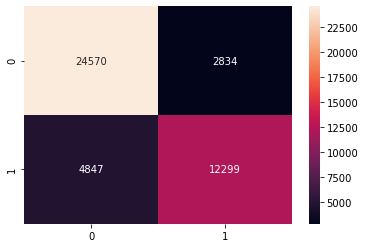

In [34]:
cm = confusion_matrix(y_train, dt_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Difference can be seen more on this model. Confusion matrix from cross_val_predict matches closely with cross validated scores.

Decision tree model shows improvement. f1 score increased to 76%, with a precision of 81% and a recall of 72%.

In [35]:
model_results = model_results.append({'Model': 'dt_model_pipe',
                      'mean f1_score': round(cv_dt['test_f1'].mean(), 4),
                      'std f1_score': round(cv_dt['test_f1'].std(), 4),
                      'mean precision': round(cv_dt['test_precision'].mean(), 4),
                      'mean recall': round(cv_dt['test_recall'].mean(), 4)}, ignore_index = True)

### Random forest
Instead of tuning decision tree parameters for better performance. We can use random forest, which performs multiple decision trees and aggregates their results.

In [36]:
rfc = RandomForestClassifier(random_state=42)
rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

In [37]:
cv_rf = cross_validate(rfc_model_pipe, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

In [38]:
cv_rf['test_f1'].mean()

0.7825739241638272

In [39]:
cv_rf['test_f1'].std()

0.004124359544450728

In [40]:
cv_rf['test_precision'].mean()

0.837488527419608

In [41]:
cv_rf['test_recall'].mean()

0.7344564922581955

Random forest model much better with a f1 score of 78%, precision and recall also increased to 84% and 74%.

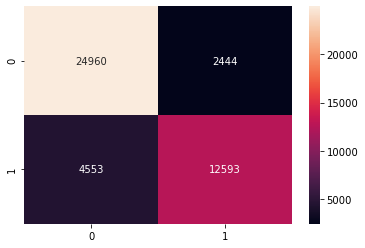

In [42]:
rfc_hat = cross_val_predict(rfc_model_pipe, X_train, y_train, cv = 5)

cm = confusion_matrix(y_train, rfc_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Small improvements can be seen from confusion matrix. False positive and false negatives are decreasing while true positives are increasing.

In [43]:
model_results = model_results.append({'Model': 'rfc_model_pipe',
                      'mean f1_score': round(cv_rf['test_f1'].mean(), 4),
                      'std f1_score': round(cv_rf['test_f1'].std(), 4),
                      'mean precision': round(cv_rf['test_precision'].mean(), 4),
                      'mean recall': round(cv_rf['test_recall'].mean(), 4)}, ignore_index = True)

#### Tuning parameters with RandomSearchCV

Utilizing randomsearchcv to find best parameters. Optimizing for f1 score to find highest balance between precision and recall.

In [44]:
random_grid = {"rfc__n_estimators": [100, 200, 300],
               "rfc__criterion": ["gini", "entropy"],
               "rfc__max_features": ['sqrt', 'log2', None],
               "rfc__min_samples_split": [2, 4, 6, 8],
               "rfc__max_depth": [None, 5, 10, 15],
               "rfc__min_samples_leaf": [1, 5, 10, 20]}

rf_random = RandomizedSearchCV(estimator = rfc_model_pipe, param_distributions = random_grid, n_iter = 100, cv = 5, random_state=42, scoring = ['f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')


In [45]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['funder',
                                                                                'installer',
                                                                                'basin',
                                                                                'lga',
                                                                                'extraction_type_group',
                                                          

In [46]:
rf_random.best_params_

{'rfc__n_estimators': 300,
 'rfc__min_samples_split': 6,
 'rfc__min_samples_leaf': 1,
 'rfc__max_features': 'sqrt',
 'rfc__max_depth': None,
 'rfc__criterion': 'entropy'}

In [47]:
idx = rf_random.best_index_

In [48]:
rf_random.best_score_

0.7878450191450523

In [49]:
rf_random.cv_results_['std_test_f1'][idx]

0.0062630456679591585

In [50]:
rf_random.cv_results_['mean_test_precision'][idx]

0.8564795885484692

In [51]:
rf_random.cv_results_['mean_test_recall'][idx]

0.7294990507138988

Random search found a model with slightly better results. f1_score of 78.7%, with precision at 85.6% and recall at 72.8%.

In [52]:
rf_bestf1 = rf_random.best_estimator_

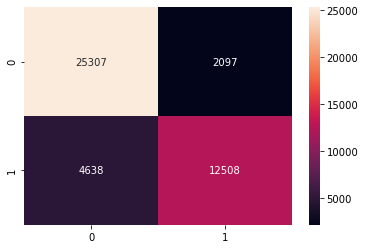

In [53]:
rf_hat = cross_val_predict(rf_bestf1, X_train, y_train, cv = 5)

cm = confusion_matrix(y_train, rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Confusion matrix shows the increase in precision with a decrease in false positives (2441 to 2094) and the decrease in recall with a increase in false negatives (4536 to 4653) and a decrease in True positives (12610 to 12493) compared to random forest model with default parameters.

In [54]:
model_results = model_results.append({'Model': 'rf_bestf1',
                      'mean f1_score': round(rf_random.best_score_, 4),
                      'std f1_score': round(rf_random.cv_results_['std_test_f1'][idx], 4),
                      'mean precision': round(rf_random.cv_results_['mean_test_precision'][idx], 4),
                      'mean recall': round(rf_random.cv_results_['mean_test_recall'][idx], 4)}, ignore_index = True)

Examining feature importance of model to find which features have the greatest effect on predictions.

In [55]:
# creating a function that retrieves feature importance of model

def get_feature_importances(model, num_top_features):
    
    # getting feature importance from model
    importances = model.steps[1][1].feature_importances_
    
    #getting feature names
    features = model['ct'].get_feature_names()
    
    # making a list of the default prefixes from feature names (ohe__x0 to ohe__x12)
    
    ohe_list = []
    for i in range(0,13):
        key = 'ohe__x'+str(i)
        ohe_list.append(key)

    # creating a dictionary to replace ohe prefixes with correct column names
    # replacing double digit prefixes first (10, 11, 12)
    dic = {}
    for i in range(10, 13):
        key = ohe_list[i]
        value = cat_cols[i]
        dic[key] = value

    feature_df = pd.Series(features)

    feature_df.replace(dic, regex = True, inplace = True) 

    # replacing prefixes 0-9 
    dic = {}
    for i in range(0, 10):
        key = ohe_list[i]
        value = cat_cols[i]
        dic[key] = value

    feature_df.replace(dic, regex = True, inplace = True)

    features_prefix = list(feature_df)
    
    # sorting indexes descending order
    indices = np.argsort(importances)

    num_features = num_top_features
    
    # plotting feature importances  
    plt.figure(figsize=(20,15))
    plt.title('Feature Importances', fontsize = 25)
    plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
    plt.yticks(range(num_features), [features_prefix[i] for i in indices[-num_features:]], fontsize = 15)
    plt.xlabel('Relative Importance', fontsize = 20)
    plt.show()

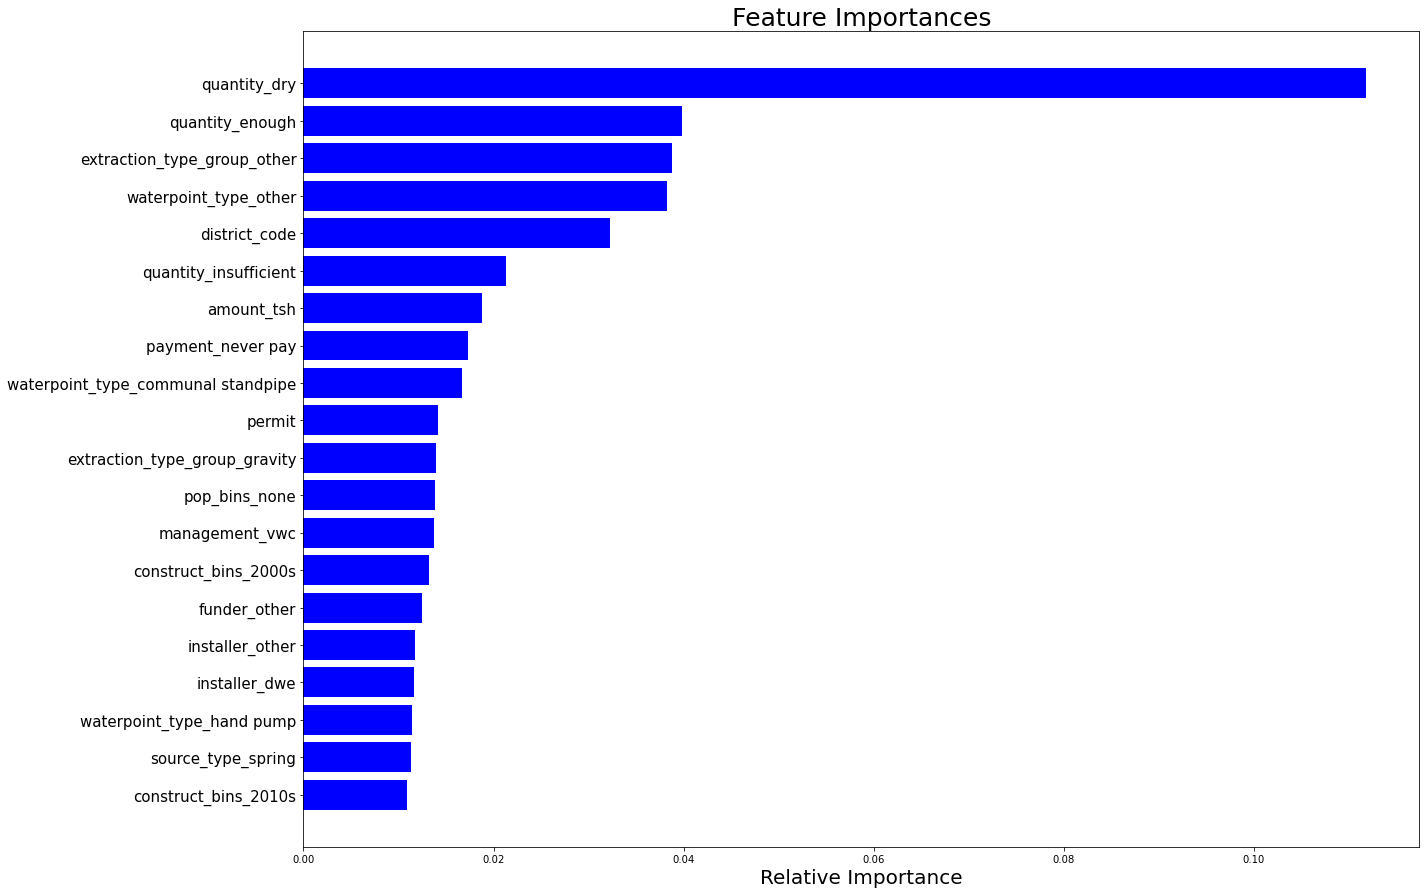

In [56]:
get_feature_importances(rf_bestf1, 20)

Out of the top 20 on the feature importance list, there are multiple features with quantity, waterpoint_type, and extraction_type_group, with quantity_dry having the most importance. Since we have one hot encoded these variables, we are getting the feature importances of each individual category. 

Permutation importance can help show importance of the complete feature instead of individual categories, by applying the function to the pipeline.

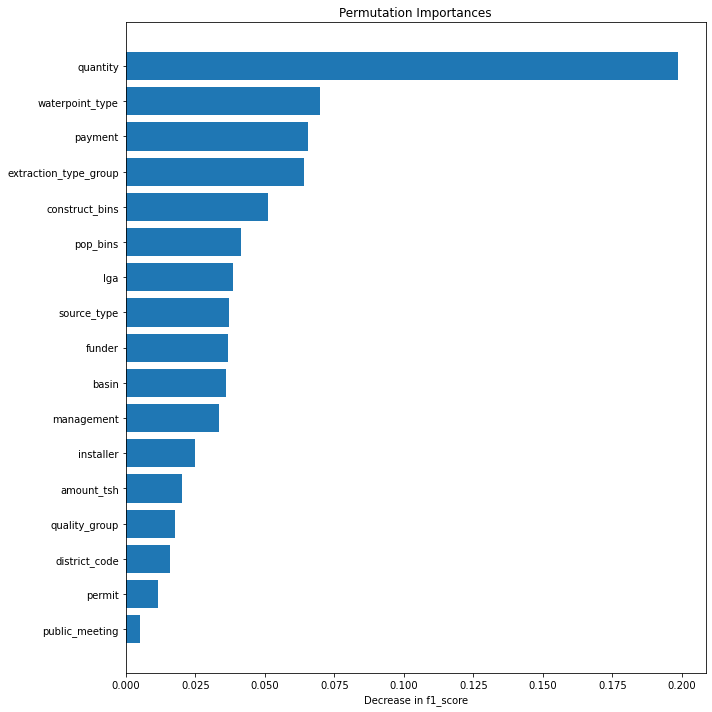

In [57]:
result = permutation_importance(
    rf_bestf1, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2, scoring = 'f1'
)

sorted_importances_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,10))

ax.barh(X_test.columns[sorted_importances_idx], result.importances[sorted_importances_idx].mean(axis=1).T)
ax.set_title('Permutation Importances')
ax.set_xlabel('Decrease in f1_score')
fig.tight_layout()
plt.show()

Permutation importance shows quantity feature has the greatest effect on the models f1_score.

### XGBoost 

Checking to see if XG Boost can do better than random forest.

In [58]:
xgb = XGBClassifier(random_state = 42)
xgb_model_pipe = Pipeline([('ct', CT), ('xgb', xgb)])

In [59]:
cv_xgb = cross_validate(xgb_model_pipe, X_train, y_train, cv = 5, scoring = ['f1', 'precision', 'recall'])

In [60]:
cv_xgb['test_f1'].mean()

0.761803144954418

In [61]:
cv_xgb['test_f1'].std()

0.003695104365799824

In [62]:
cv_xgb['test_precision'].mean()

0.8640172447953635

In [63]:
cv_xgb['test_recall'].mean()

0.6812662532829654

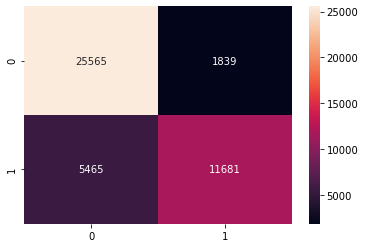

In [64]:
xgb_hat = cross_val_predict(xgb_model_pipe, X_train, y_train, cv = 5)

cm = confusion_matrix(y_train, xgb_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

XGB model performed well with default settings, 76% f1 score, 86% precision and 68% recall. We will see if we can tune hyperparameters to optimize based on f1 score to get better results.

In [65]:
model_results = model_results.append({'Model': 'xgb_model_pipe',
                      'mean f1_score': round(cv_xgb['test_f1'].mean(), 4),
                      'std f1_score': round(cv_xgb['test_f1'].std(), 4),
                      'mean precision': round(cv_xgb['test_precision'].mean(), 4),
                      'mean recall': round(cv_xgb['test_recall'].mean(), 4)}, ignore_index = True)

In [66]:
random_grid = {'xgb__n_estimators': [100, 200, 300],
               'xgb__subsample': [0.6, 0.8, 1.0],
               'xgb__colsample_bytree': [0.6, 0.8, 1.0],
               'xgb__learning_rate': [0.05, 0.10, 0.20, 0.30],
               'xgb__gamma': [0.5, 1, 5, 10],
               'xgb__max_depth': sp_randInt(3, 10),
               'xgb__min_child_weight': sp_randInt(1, 10)}

xgb_random = RandomizedSearchCV(estimator = xgb_model_pipe, param_distributions = random_grid, n_iter = 100, cv = 5, random_state=42, scoring = ['f1', 'precision', 'recall'], n_jobs = -1, refit = 'f1')

In [67]:
xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['funder',
                                                                                'installer',
                                                                                'basin',
                                                                                'lga',
                                                                                'extraction_type_group',
                                                          

In [68]:
xgb_random.best_params_

{'xgb__colsample_bytree': 1.0,
 'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.3,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 3,
 'xgb__n_estimators': 200,
 'xgb__subsample': 1.0}

In [69]:
i = xgb_random.best_index_

In [70]:
xgb_random.best_score_

0.7850714990559383

In [71]:
xgb_random.cv_results_['std_test_f1'][i]

0.004852493092734454

In [72]:
xgb_random.cv_results_['mean_test_precision'][i]

0.8524636250303409

In [73]:
xgb_random.cv_results_['mean_test_recall'][i]

0.7275743763322102

Tuned XGB model performed better than default XGB model with f1_score of 78.6%, precision 85% and recall 73%.

In [74]:
xgb_bestf1 = xgb_random.best_estimator_

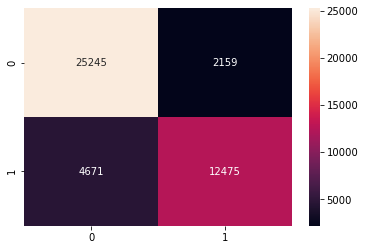

In [75]:
xgb_bestf1_hat = cross_val_predict(xgb_bestf1, X_train, y_train, cv = 5)

cm = confusion_matrix(y_train, xgb_bestf1_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Results are similar to rf_bestf1 model.

In [76]:
model_results = model_results.append({'Model': 'xgb_bestf1',
                      'mean f1_score': round(xgb_random.best_score_, 4),
                      'std f1_score': round(xgb_random.cv_results_['std_test_f1'][i], 4),
                      'mean precision': round(xgb_random.cv_results_['mean_test_precision'][i], 4),
                      'mean recall': round(xgb_random.cv_results_['mean_test_recall'][i], 4)}, ignore_index = True)

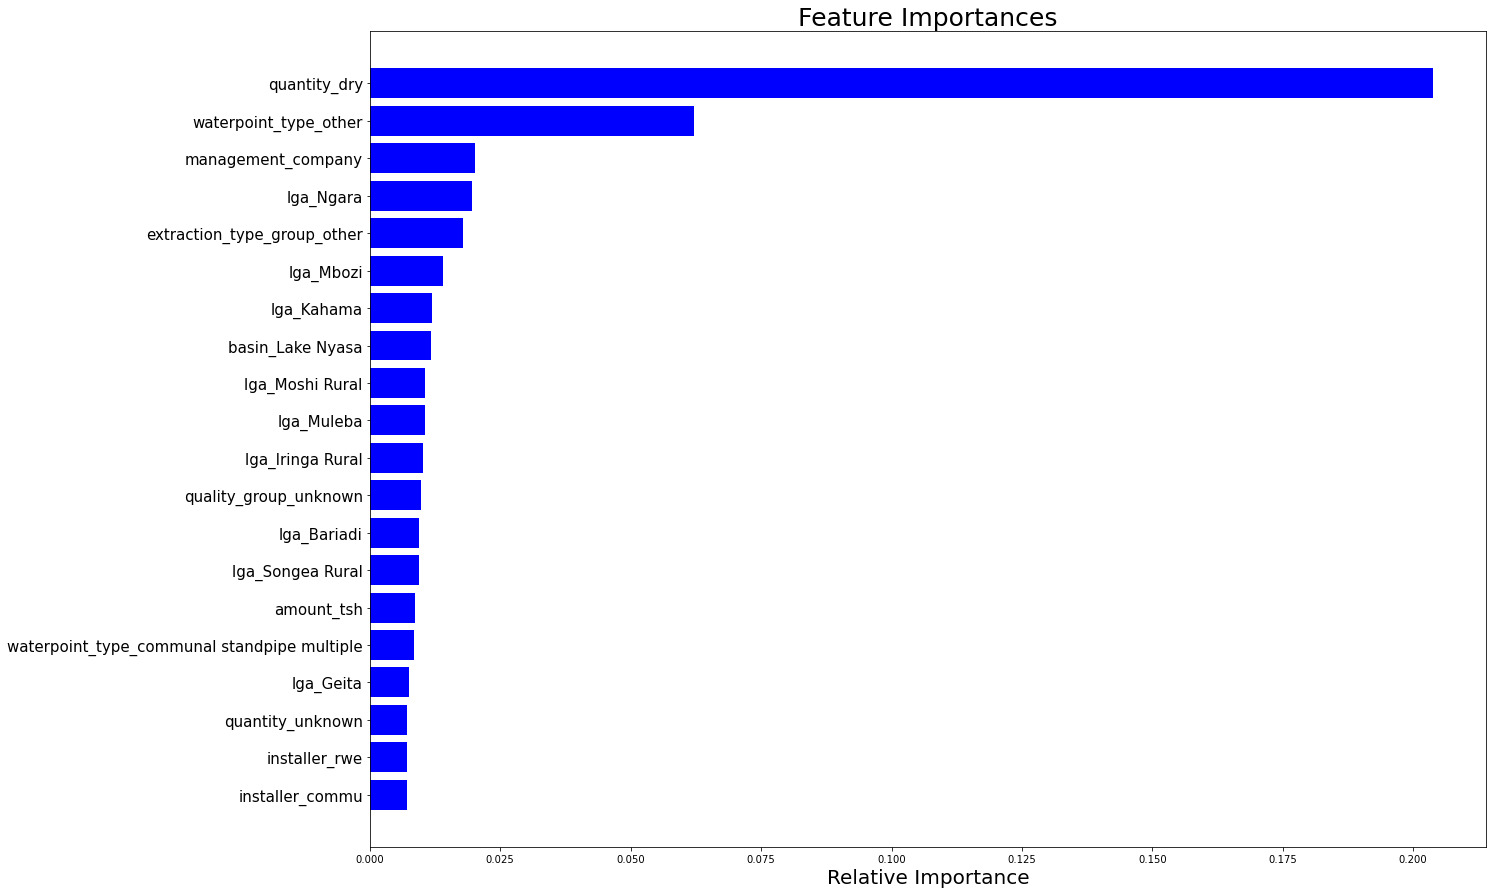

In [77]:
get_feature_importances(xgb_bestf1, 20)

Interestingly, feature importances shows multiple features from lga. quantity_dry still has the greatest effect on prediction in this model as well.

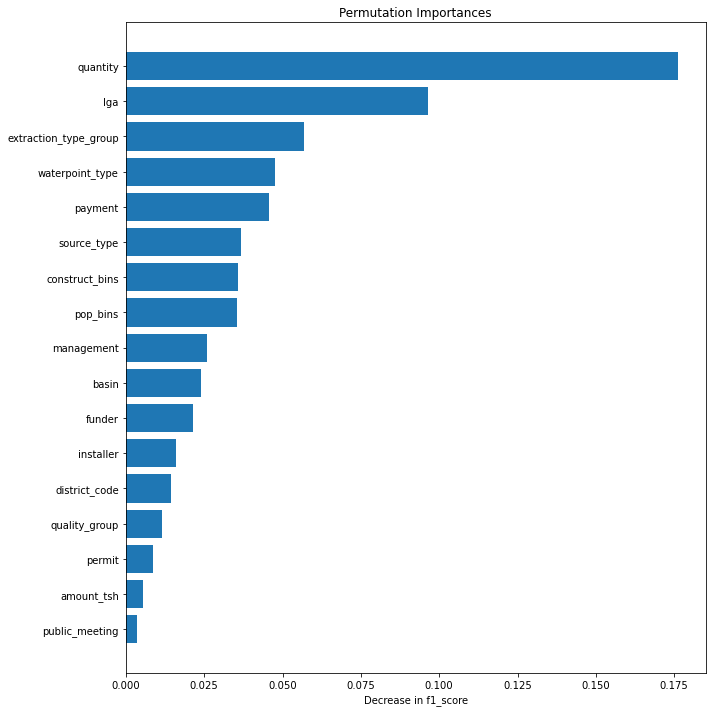

In [118]:
result_xgb = permutation_importance(
    xgb_bestf1, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2, scoring = 'f1'
)

sorted_importances_idx_xgb = result_xgb.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (10,10))

ax.barh(X_test.columns[sorted_importances_idx_xgb], result_xgb.importances[sorted_importances_idx_xgb].mean(axis=1).T)
ax.set_title('Permutation Importances')
ax.set_xlabel('Decrease in f1_score')
fig.tight_layout()
plt.show()

Permutaion importances are similar compared to random forest model, other than lga feature being second highest.

## Model Evaluations

In [79]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,logred_model_pipe,0.7224,0.0047,0.8200,0.6456
1,dt_model_pipe,0.7620,0.0054,0.8127,0.7173
2,rfc_model_pipe,0.7826,0.0041,0.8375,0.7345
3,rf_bestf1,0.7878,0.0063,0.8565,0.7295
4,xgb_model_pipe,0.7618,0.0037,0.8640,0.6813
5,xgb_bestf1,0.7851,0.0049,0.8525,0.7276


Out of the different models rf_bestf1 and xgb_bestf1 performed similarly the best. Random forest model has slightly higher precision score than XGB. We can compare precision and recall scores of both models to see if this is the case across different decision thresholds.

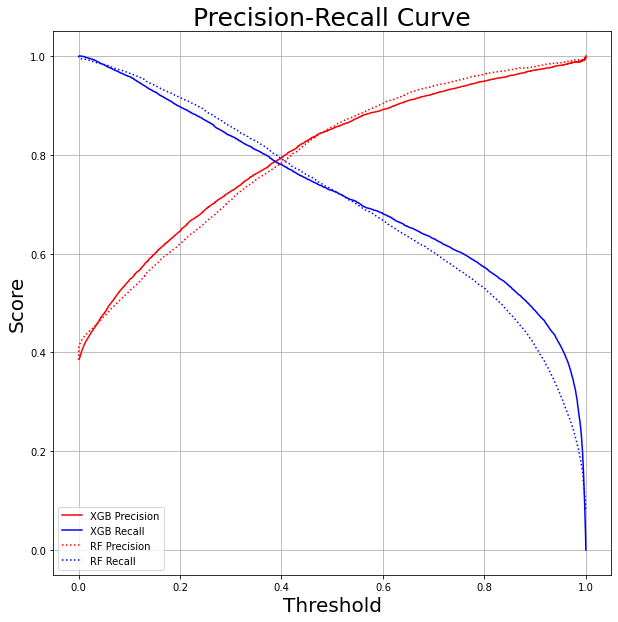

In [80]:
pred_prob_xgb = cross_val_predict(xgb_bestf1, X_train, y_train, cv = 5, method = 'predict_proba')
precision_xgb, recall_xgb, threshold_xgb = precision_recall_curve(y_train, pred_prob_xgb[:, 1])

pred_prob_rf = cross_val_predict(rf_bestf1, X_train, y_train, cv = 5, method = 'predict_proba')
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train, pred_prob_rf[:, 1])

plt.figure(figsize=(10,10))

plt.plot(threshold_xgb, precision_xgb[:-1], c ='r', label ='XGB Precision')
plt.plot(threshold_xgb, recall_xgb[:-1], c ='b', label ='XGB Recall')

plt.plot(threshold_rf, precision_rf[:-1], c ='r', ls = ':', label ='RF Precision')
plt.plot(threshold_rf, recall_rf[:-1], c ='b', ls = ':', label ='RF Recall')

plt.grid()
plt.legend()
plt.title('Precision-Recall Curve', fontsize = 25)
plt.xlabel('Threshold', fontsize = 20)
plt.ylabel('Score', fontsize = 20)
plt.show();

As threshold increases past around 0.4 rf_bestf1 model has higher precision but lower recall than xgb_bestf1 model. We will go with random forest model over XGB model.

### Decision Threshold
We can adjust decision threshold to increase model's precision depending on the costs of false positives. We will compare performance of moving threshold on model optimized for f1 score and model optimized for precision.

In [81]:
THRESHOLD = 0.6
preds = np.where(pred_prob_rf[:,1] > THRESHOLD, 1, 0)

In [82]:
thres_p = precision_score(y_train, preds)
thres_p

0.9035392637067468

In [83]:
thres_r = recall_score(y_train, preds)
thres_r

0.6670360433920448

In [84]:
thres_f1 = f1_score(y_train, preds)
thres_f1

0.7674808750503289

Moving threshold to 0.6 we are able to obtain 90% precision and 67% recall.

In [85]:
model_results = model_results.append({'Model': 'rf_bestf1 threshold = 0.6',
                      'mean f1_score': round(thres_f1, 4),
                      'mean precision': round(thres_p, 4),
                      'mean recall': round(thres_r, 4)}, ignore_index = True)

In [91]:
cv_df = pd.DataFrame(rf_random.cv_results_)

In [93]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__n_estimators,param_rfc__min_samples_split,param_rfc__min_samples_leaf,param_rfc__max_features,param_rfc__max_depth,param_rfc__criterion,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,10.529785,0.340510,0.657438,0.119147,100,6,10,sqrt,5,gini,...,0.008372,29,0.462682,0.451152,0.430446,0.450569,0.443278,0.447625,0.010600,90
1,19.776728,0.655957,0.881850,0.017827,200,8,10,sqrt,5,entropy,...,0.009348,19,0.458601,0.454360,0.438320,0.463400,0.440653,0.451067,0.009906,85
2,83.903599,1.239415,2.861964,0.065436,300,6,1,sqrt,None,entropy,...,0.006004,92,0.738776,0.723243,0.717410,0.745698,0.722368,0.729499,0.010813,7
3,101.589011,1.008153,0.594034,0.041959,100,2,1,None,5,gini,...,0.005293,81,0.519242,0.490814,0.501312,0.505687,0.503645,0.504140,0.009125,65
4,409.960048,13.515140,1.449683,0.041227,200,6,20,None,None,entropy,...,0.002620,75,0.667638,0.648877,0.652377,0.671041,0.661709,0.660329,0.008538,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.356907,0.154927,0.816047,0.049290,100,8,10,log2,15,gini,...,0.004504,41,0.557143,0.540974,0.533100,0.554972,0.534558,0.544149,0.010101,50
96,47.469915,0.188503,1.611692,0.015358,300,8,1,sqrt,10,entropy,...,0.005316,32,0.565015,0.538349,0.537474,0.553223,0.528434,0.544499,0.012979,49
97,223.850349,32.136843,0.642001,0.168689,100,2,1,None,None,gini,...,0.002888,100,0.746647,0.729076,0.728201,0.744532,0.728201,0.735331,0.008409,2
98,6.069547,0.056940,0.566632,0.028403,100,4,1,log2,5,entropy,...,0.008581,3,0.303499,0.301546,0.279965,0.309711,0.298921,0.298728,0.010034,94


In [98]:
cv_df_90 = cv_df[(cv_df['mean_test_precision'] > 0.90) & (cv_df['mean_test_precision'] < 0.91)]
cv_df_90[['mean_test_precision', 'mean_test_recall']].sort_values('mean_test_precision', ascending = False)

,mean_test_precision,mean_test_recall
26,0.906937,0.540300
43,0.905888,0.540300
44,0.904852,0.540475
71,0.904533,0.563921
66,0.904402,0.547707
95,0.904388,0.544149
15,0.904102,0.590049
68,0.902685,0.539017
49,0.902338,0.550390
94,0.902338,0.550390


Based on random search results if we had tuned parameters for precision, recall does not perform anywhere close. we will select rf_bestf1 as our final model.

## Final Model
Evaluating model on test set.

In [99]:
rf_bestf1

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['funder', 'installer',
                                                   'basin', 'lga',
                                                   'extraction_type_group',
                                                   'management', 'payment',
                                                   'quality_group', 'quantity',
                                                   'source_type',
                                                   'waterpoint_type',
                                                   'pop_bins',
                                                   'construct_bins'])])),
                ('rfc',
                 Rando

In [100]:
y_pred = rf_bestf1.predict(X_test)

In [101]:
f1_score(y_test, y_pred)

0.7865083135391924

In [102]:
precision_score(y_test, y_pred)

0.8539302661440066

In [103]:
recall_score(y_test, y_pred)

0.7289538569918985

In [104]:
model_results[model_results.Model == 'rf_bestf1']

,Model,mean f1_score,std f1_score,mean precision,mean recall
3,rf_bestf1,0.7878,0.0063,0.8565,0.7295


f1, precision, and recall scores are similar to our cross validation scores. This is a good sign that our model is not over fitting on the training data.

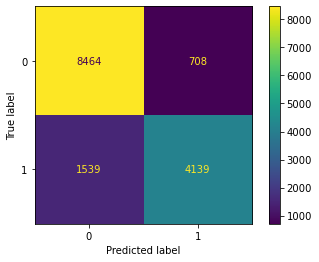

In [105]:
plot_confusion_matrix(rf_bestf1, X_test, y_test);

Comparing precision and recall curves on different thresholds.

Text(0, 0.5, 'Score')

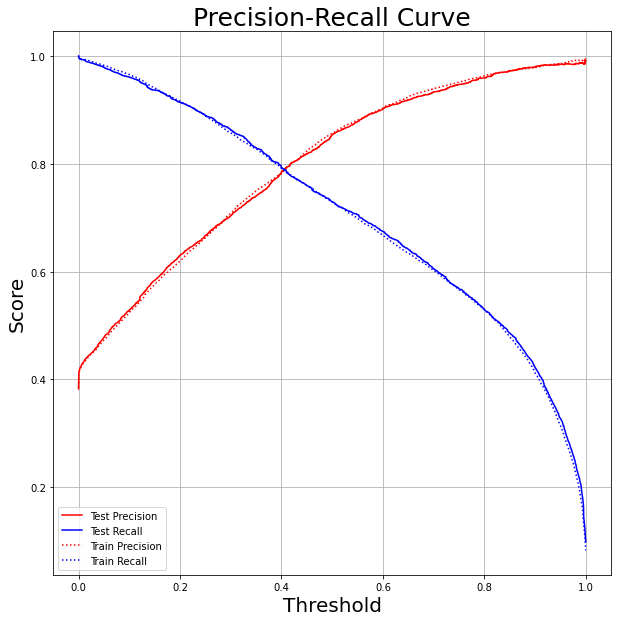

In [106]:
y_pred_proba = rf_bestf1.predict_proba(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(10,10))

plt.plot(threshold, precision[:-1], c ='r', label ='Test Precision')
plt.plot(threshold, recall[:-1], c ='b', label ='Test Recall')

plt.plot(threshold_rf, precision_rf[:-1], c ='r', ls = ':', label ='Train Precision')
plt.plot(threshold_rf, recall_rf[:-1], c ='b', ls = ':', label ='Train Recall')

plt.grid()
plt.legend()
plt.title('Precision-Recall Curve', fontsize = 25)
plt.xlabel('Threshold', fontsize = 20)
plt.ylabel('Score', fontsize = 20)

In [107]:
THRESHOLD = 0.6
preds = np.where(y_pred_proba[:,1] > THRESHOLD, 1, 0)

In [108]:
precision_score(y_test, preds)

0.9013653483992468

In [109]:
recall_score(y_test, preds)

0.6743571680169074

In [110]:
model_results[model_results.Model == 'rf_bestf1 threshold = 0.6']

,Model,mean f1_score,std f1_score,mean precision,mean recall
6,rf_bestf1 threshold = 0.6,0.7675,NaN,0.9035,0.667


Precision and recall from test set is also similar to train results across all thresholds.

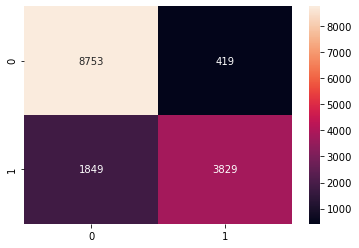

In [111]:
cm = confusion_matrix(y_test, preds)
f = sns.heatmap(cm, annot=True, fmt = 'g')

We can adjust decision threshold to increase precision to lower false positives, but that comes at a cost to recall, increasing false negatives and lowering true positives as well.

## Conclusion

Examining top features found from permutation importance.

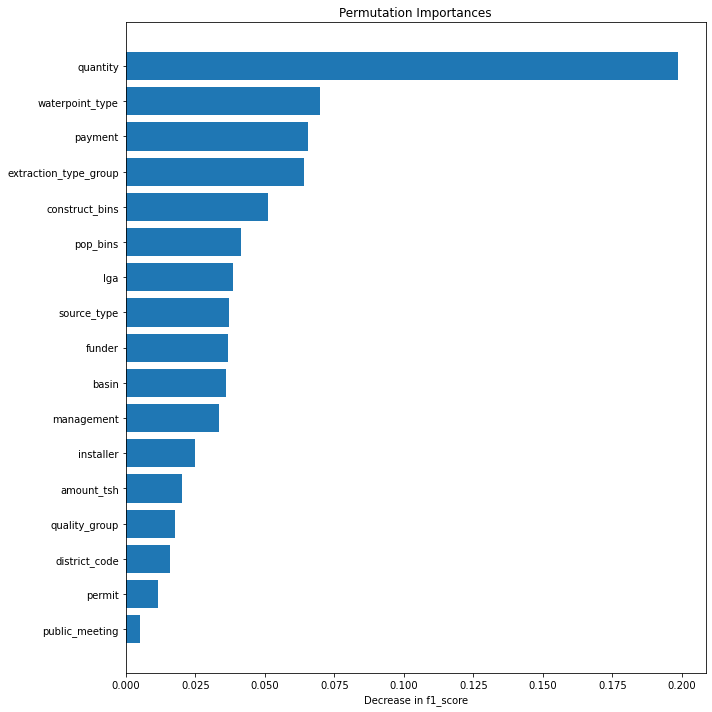

In [131]:
fig, ax = plt.subplots(figsize = (10,10))

ax.barh(X_test.columns[sorted_importances_idx], result.importances[sorted_importances_idx].mean(axis=1).T)
ax.set_title('Permutation Importances')
ax.set_xlabel('Decrease in f1_score')
fig.tight_layout()
fig.savefig('images/permutaion.png')

In [120]:
def plot_features(feature, order = None, fname = False):
    if order != None:
        data[feature] = pd.Categorical(data[feature], categories = order, ordered = True)
        df_grouped = data.groupby(feature)['status_group'].value_counts(normalize = True).unstack('status_group')
    else:
        df_grouped = data.groupby(feature)['status_group'].value_counts(normalize=True).unstack('status_group').sort_values('functional')

    fig, ax = plt.subplots()    
        
    df_grouped.plot.barh(figsize = (15,10), stacked = True, ax = ax);
    for rect in ax.patches:
        # find where each bar is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
    
        # The height of the bar is the data value and can be used as the label
        label_text = f'{(width*100):.1f}%'  # format text to show only 1 decimal place in percentage
    
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
    
        # only plot labels greater than given width
        if width > 0.05:
            ax.text(label_x, label_y, label_text, ha='center', va='center',\
                    fontsize=15)

    # move the legend
    ax.legend(bbox_to_anchor=(0.5, 1),
            loc="lower center",
            borderaxespad=0,
            frameon=False,
            ncol=2)

    ax.xaxis.set_ticklabels([])
    
    # save file to images folder if specified
    if fname:
        fig.savefig(('images/' + fname), dpi=200)

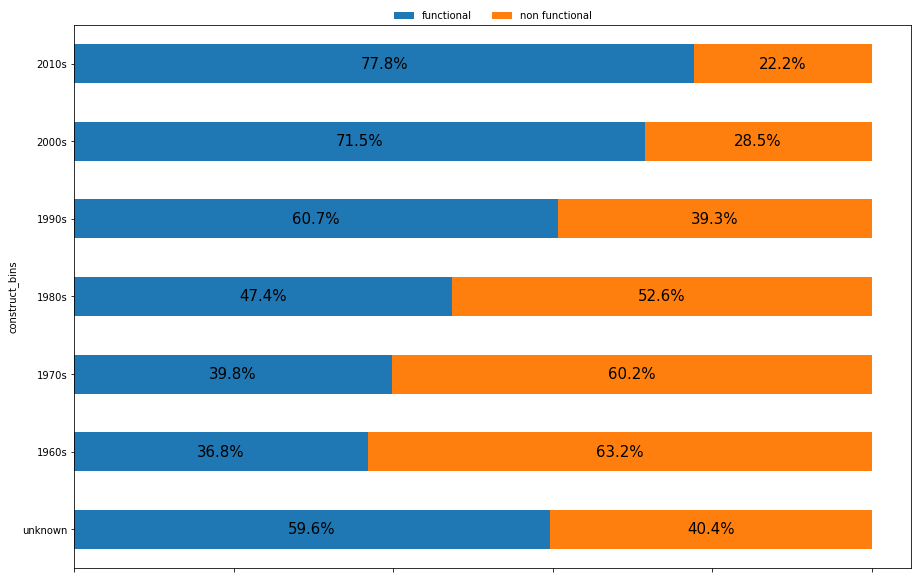

In [121]:
order = ['unknown', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']
plot_features('construct_bins', order = order, fname = 'construcion')

Older waterpoints have a higher percentage of non functional.

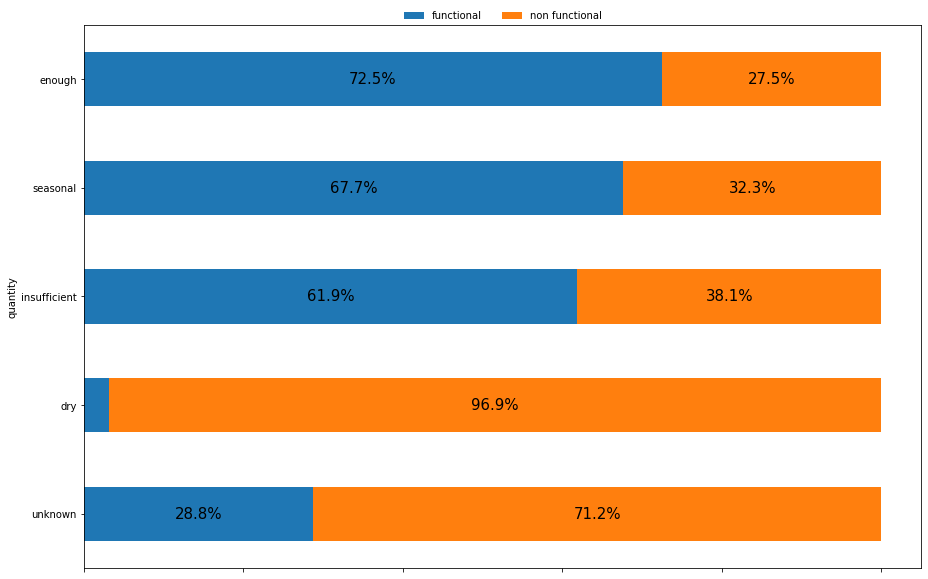

In [122]:
order= ['unknown', 'dry', 'insufficient', 'seasonal', 'enough']
plot_features('quantity', order = order, fname = 'quantity')

Dried up waterpoints have the highest majority of non functional.

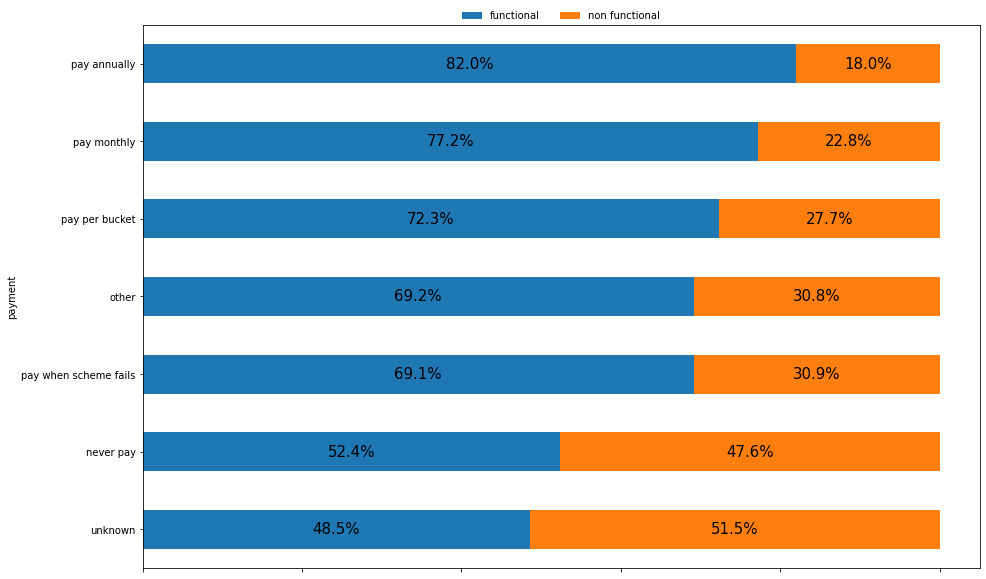

In [123]:
plot_features('payment', fname = 'payment.png')

Free to use waterpoints have the most non functional.

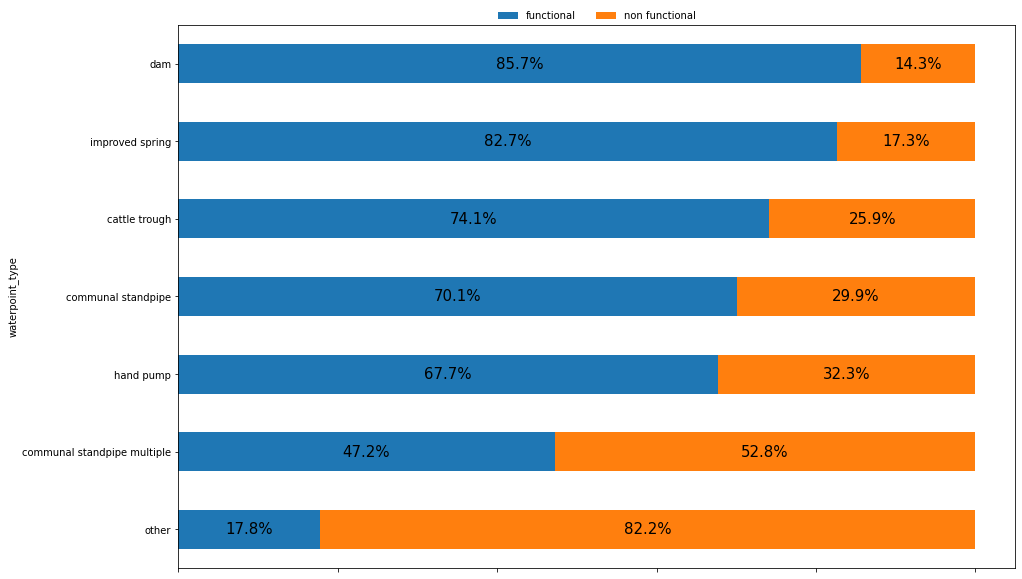

In [124]:
plot_features('waterpoint_type', fname = 'waterpoint_type')

In [125]:
data.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

Improved spring, dam, and cattle trough type waterpoints had less non functional, but there are low amounts of these types compared to others. Communal standpipe multiple and other has the most non functional.

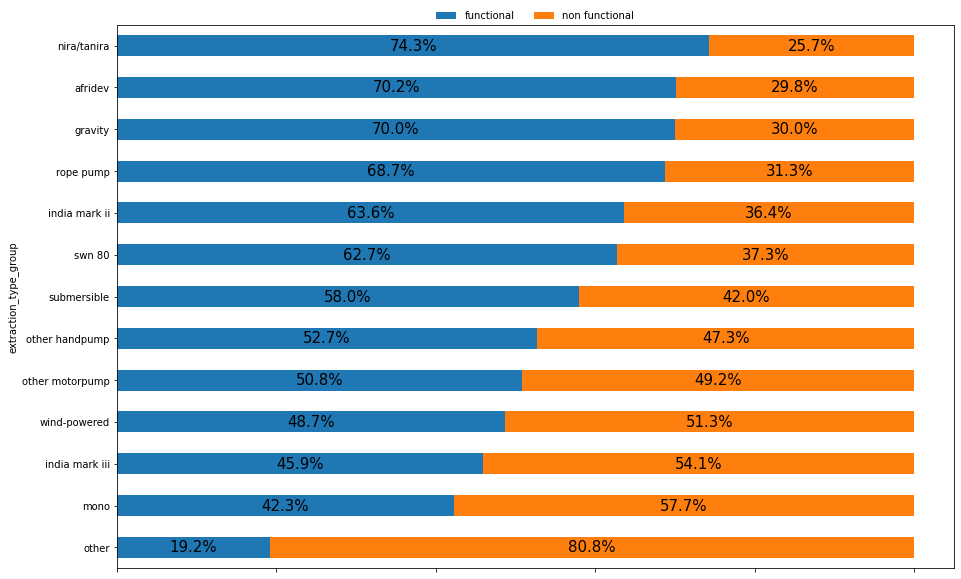

In [126]:
plot_features('extraction_type_group', fname = 'extraction')

4 out of the top 6 extraction type were different models of handpumps (nira/tanira, afridev, india mark ii, and swn 80). 

Overall results:

* Precision: 85%
* Recall: 73%

Model performed well optimizing both precision and recall. Depending on business needs, we can adjust decision threshold for increased precision.

## Recommendations

Based on the features that best effect predictions on the final model we can make the below recommendations.

* Service older waterpoints.
* Find methods to deal with dry waterpoints.
* Allocate resources to help maintain non payment waterpoints.
* improved spring, dam, and cattle trough type waterpoints had less non functional, but there are less of these types probably due to availability of location or cost. We can recommend communal standpipes or hand pumps over communal standpipe multiple and other.
* hand pumps performed the best out of the extraction types. With nira/tanira and afridev having the least non functionals.

## Future Considerations

* What effects functional waterpoints but needs repairs? Do they eventually lead to non functional if left unrepaired?
* There are many waterpoints with zero population. Were non functional water points abandoned for nearby functional waterpoints?
* Consider other methods of delivering clean water to citizens.

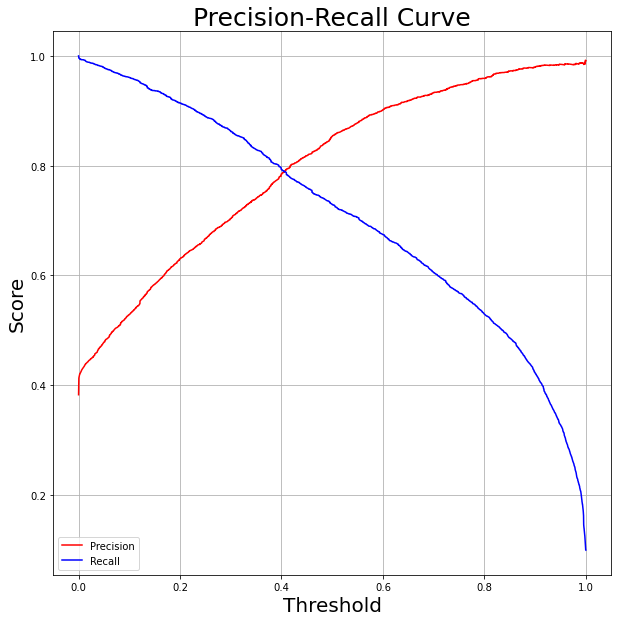

In [136]:
plt.figure(figsize=(10,10))

plt.plot(threshold, precision[:-1], c ='r', label ='Precision')
plt.plot(threshold, recall[:-1], c ='b', label ='Recall')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve', fontsize = 25)
plt.xlabel('Threshold', fontsize = 20)
plt.ylabel('Score', fontsize = 20);
plt.savefig('images/pr_curve.png')